In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
import os
import matplotlib.pyplot as plt
import torchvision.transforms as T
import torch.nn.functional as F
import tiktoken

from helper import text_to_token_ids, token_ids_to_text


In [5]:
tokenizer = tiktoken.get_encoding('gpt2')

special_tokens = {"<image>": tokenizer.n_vocab+1}
tokenizer_modified = tiktoken.Encoding(
    name="gpt2_with_image",
    pat_str=tokenizer._pat_str,
    mergeable_ranks=tokenizer._mergeable_ranks,
    special_tokens={**tokenizer._special_tokens, **special_tokens}
)

In [34]:
class OCR_dataset(Dataset):
    def __init__(self, dataset_file_name: str, files: list, tokenizer):
        super().__init__()
        self.master_files = dataset_file_name
        self.tokenizer = tokenizer

        self.files = [f.split('_') for f in files]

        self.transform = T.Compose([
            T.ToTensor(),                            
            T.Resize((1024, 1024)),                   
        ])
    
    def __getitem__(self, index):
        selected = self.files[index]
        text = selected[-1].split(".jpg")[0]

        filename = '_'.join(selected)
        path = os.path.join(self.master_files, filename)
        image_np = plt.imread(path)
        image = self.transform(image_np)
        
        input_ids = text_to_token_ids(text, self.tokenizer)
        return input_ids, image

    def __len__(self):
        return len(self.files)

dataset = OCR_dataset(dataset_file_name = 'dataset', files = os.listdir('dataset'), tokenizer = tokenizer_modified)
input_ids, image = next(iter(dataset))

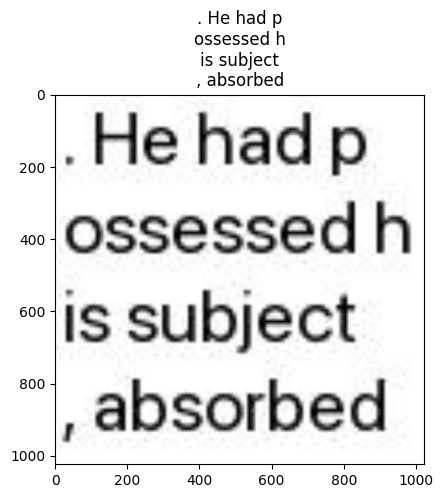

In [35]:
plt.imshow(image.permute(1,2,0).detach().numpy())
plt.title(token_ids_to_text(input_ids, tokenizer_modified))
plt.show()

In [36]:
def ocr_collate(batch):

    input_ids_list, images_list = zip(*batch)


    max_len = max(x.shape[1] for x in input_ids_list)

    padded_ids = []
    for ids in input_ids_list:
        pad_amount = max_len - ids.shape[1]
        padded = F.pad(ids, (0, pad_amount), value=50256)  # <|endoftext|>
        padded_ids.append(padded)

    padded_ids = torch.cat(padded_ids, dim=0)     
    images = torch.stack(images_list, dim=0)      

    return padded_ids, images

In [ ]:
files = os.listdir('dataset')
l = len(files)

train_frac = 0.8
test_frac  = 0.1

train_pos = int(l * train_frac)
test_pos  = int(l * test_frac)

train_files = files[: train_pos]
test_files = files[train_pos : train_pos + test_pos]
val_files  = files[train_pos + test_pos : ]

In [58]:
len(train_files), len(test_files), len(val_files)

(409, 51, 52)

In [61]:
batch_size = 8

train_dl = DataLoader(
           dataset=OCR_dataset(
               dataset_file_name = 'dataset',
               files = train_files,
               tokenizer = tokenizer_modified
               ),
           batch_size=batch_size,
           shuffle=True,
           collate_fn=ocr_collate,
           pin_memory=True,
           drop_last = True
       )

test_dl  = DataLoader(
           dataset=OCR_dataset(
               dataset_file_name = 'dataset',
               files = test_files,
               tokenizer = tokenizer_modified
               ),
           batch_size=batch_size,
           shuffle=False,
           collate_fn=ocr_collate,
           pin_memory=True,
           drop_last = True
       )

val_dl  =  DataLoader(
           dataset=OCR_dataset(
               dataset_file_name = 'dataset',
               files = val_files,
               tokenizer = tokenizer_modified
               ),
           batch_size=batch_size,
           shuffle=False,
           collate_fn=ocr_collate,
           pin_memory=True,
           drop_last = True
       )

a = next(iter(train_dl))


/Users/mohamedmafaz/Desktop/OCR Model/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


In [64]:
a[1].shape

torch.Size([8, 3, 1024, 1024])